# ThinkBrake: Threshold Sensitivity Experiment

In [12]:
import json
import pandas as pd
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

METRICS_FILE = Path("../metrics_summary.jsonl")
INCLUDE_MODELS = [
    "Qwen/Qwen3-4B-Thinking-2507",
    # "Qwen/Qwen3-4B",
    # "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
    # "microsoft/phi-4-reasoning",
]
CATEGORY = "dapo-math"
INCLUDE_THRESHOLDS = [0.1, 0.25, 1.0, 2.5, 10.0]

In [13]:
def load_metrics(file_path):
    if not file_path.exists():
        print(f"Warning: {file_path} not found.")
        return []
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return data


all_metrics = load_metrics(METRICS_FILE)
print(f"Total records loaded: {len(all_metrics)}")

Total records loaded: 1072


In [14]:
def process_model_data(model_name, benchmark, all_metrics):

    model_metrics = [
        r
        for r in all_metrics
        if (
            r.get("model") == model_name
            or r.get("model") == model_name.replace("/", "_")
        )
        and r.get("benchmark") == benchmark
    ]

    all_token_counts = [
        r.get("avg_token_length")
        for r in model_metrics
        if r.get("avg_token_length") is not None
        and r.get("threshold") in INCLUDE_THRESHOLDS
        or r.get("method") == "rollout"
    ]

    global_min_tokens = min(all_token_counts) if all_token_counts else 0
    global_max_tokens = max(all_token_counts) if all_token_counts else 0

    baseline_entry = next(
        (r for r in model_metrics if r.get("method") == "rollout"), None
    )
    base_tokens = baseline_entry.get("avg_token_length", 0) if baseline_entry else 0

    plot_data = []
    for r in model_metrics:
        if r.get("method") == "thinkbrake":
            try:
                t_val = float(r.get("threshold"))
                if not any(abs(t_val - t) < 1e-6 for t in INCLUDE_THRESHOLDS):
                    continue

                token_reduction = None
                if baseline_entry:
                    base_tokens = baseline_entry.get("avg_token_length", 0)
                    curr_tokens = r.get("avg_token_length", 0)
                    if base_tokens > 0:
                        token_reduction = (
                            (base_tokens - curr_tokens) / base_tokens * 100
                        )

                accuracy = r.get("accuracy", 0)
                avg_tok_len = r.get("avg_token_length", 0)
                token_efficiency = 1 - (avg_tok_len - global_min_tokens) / (
                    global_max_tokens - global_min_tokens
                )

                entry = {
                    "threshold": t_val,
                    "accuracy": accuracy,
                    "majority_accuracy": r.get("majority_accuracy"),
                    "avg_token_length": avg_tok_len,
                    "min_token_length": global_min_tokens,
                    "max_token_length": global_max_tokens,
                    "token_reduction": token_reduction,
                    "e3_score": accuracy * accuracy / avg_tok_len,
                    "token_efficiency": token_efficiency,
                    "overthinking_score": (2 * accuracy * token_efficiency)
                    / (accuracy + token_efficiency),
                }
                plot_data.append(entry)
            except (ValueError, TypeError):
                continue

    df = pd.DataFrame(plot_data)
    if not df.empty:
        df = df.sort_values("threshold")

    return df, baseline_entry

In [15]:
processed_data = {}
for model in INCLUDE_MODELS:
    df, baseline = process_model_data(model, CATEGORY, all_metrics)
    if not df.empty or baseline:
        processed_data[model] = {"df": df, "baseline": baseline}
        print(
            f"Processed {model}: {len(df)} ThinkBrake points, Baseline found: {baseline is not None}"
        )
    else:
        print(f"No data found for {model}")

Processed Qwen/Qwen3-4B-Thinking-2507: 5 ThinkBrake points, Baseline found: True


In [16]:
for model, data in processed_data.items():
    df = data["df"]
    baseline = data["baseline"]
    display_name = model.split("/")[-1]
    summary_list = []

    if baseline:
        g_min = (
            df["min_token_length"].iloc[0]
            if not df.empty
            else baseline.get("avg_token_length", 0)
        )
        g_max = (
            df["max_token_length"].iloc[0]
            if not df.empty
            else baseline.get("avg_token_length", 0)
        )

        b_acc = baseline.get("accuracy", 0)
        b_len = baseline.get("avg_token_length", 0)
        b_eff = 1 - (b_len - g_min) / (g_max - g_min) if (g_max - g_min) > 0 else 1.0

        summary_list.append(
            {
                "Model": display_name,
                "Threshold": "--",
                "Accuracy": b_acc,
                "Avg Tokens": b_len,
                "E3 Score": (b_acc**2) / b_len if b_len > 0 else 0,
                # "Efficiency": b_eff,
                "Overthinking": "--",
            }
        )

    for _, row in df.iterrows():
        summary_list.append(
            {
                "Model": display_name,
                "Threshold": row["threshold"],
                "Accuracy": row["accuracy"],
                "Avg Tokens": row["avg_token_length"],
                "E3 Score": row["e3_score"],
                # "Efficiency": row["token_efficiency"],
                "Overthinking": row["overthinking_score"],
            }
        )

    summary_df = pd.DataFrame(summary_list)
    pd.set_option("display.max_rows", None)
    pd.set_option("display.float_format", "{:.2f}".format)
    display(summary_df)

,Model,Threshold,Accuracy,Avg Tokens,E3 Score,Overthinking
0,Qwen3-4B-Thinking-2507,--,73.00,13904.49,0.38,--
1,Qwen3-4B-Thinking-2507,0.10,82.33,10225.15,0.66,0.75
2,Qwen3-4B-Thinking-2507,0.25,79.00,9755.87,0.64,0.85
3,Qwen3-4B-Thinking-2507,1.00,80.67,8718.52,0.75,1.06
4,Qwen3-4B-Thinking-2507,2.50,74.33,7196.75,0.77,1.37
5,Qwen3-4B-Thinking-2507,10.00,63.00,4194.38,0.95,1.97


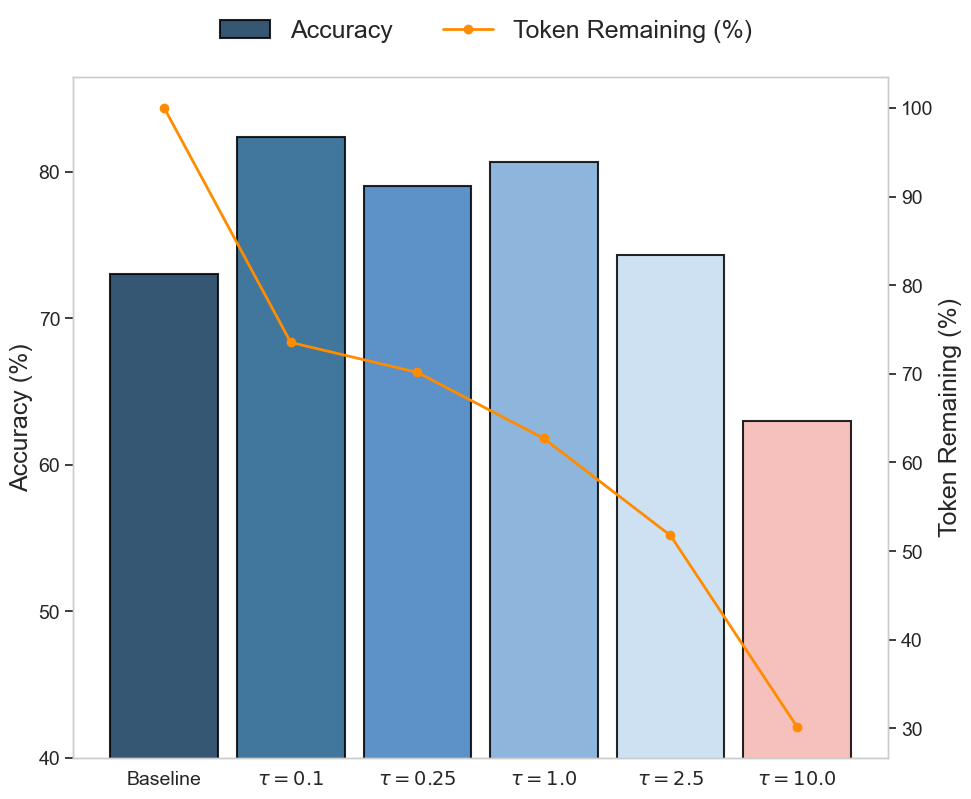

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update(
    {
        "font.size": 16,
        "axes.titlesize": 18,
        "axes.labelsize": 18,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 18,
        "lines.linewidth": 2.0,
        "axes.linewidth": 1.0,
    }
)

bar_colors = [
    "#123A5A",
    "#1F5F8B",
    "#3F7FBF",
    "#7AAAD6",
    "#C6DCF0",
    "#F5B7B1",
    "#F1948A",
    "#EC7063",
    "#E74C3C",
    "#B03A2E",
]

for model, data in processed_data.items():
    df = data["df"]
    baseline = data["baseline"]
    display_name = model.split("/")[-1]

    # -----------------------------
    # Create figure (single column)
    # -----------------------------
    fig, ax = plt.subplots(figsize=(10, 8))

    if df.empty:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        plt.show()
        continue

    # Add baseline to the dataframe for plotting
    if baseline:
        baseline_row = {
            "threshold": 0.0,  # Use 0.0 for baseline threshold
            "accuracy": baseline.get("accuracy", 0),
            "token_reduction": 0.0,  # 0% reduction for baseline
            "avg_token_length": baseline.get("avg_token_length", 0),
        }
        plot_df = pd.concat([pd.DataFrame([baseline_row]), df], ignore_index=True)
    else:
        plot_df = df

    x_pos = np.arange(len(plot_df))

    # Accuracy bar with color coding
    colors = [bar_colors[i % len(bar_colors)] for i in range(len(plot_df))]
    ax.bar(
        x_pos,
        plot_df["accuracy"],
        width=0.85,
        color=colors,
        alpha=0.85,
        label="Accuracy",
        edgecolor="black",
        linewidth=1.5,
    )

    # Remove gridlines
    ax.grid(False)

    # Token remaining line (baseline = 100%, decreases with reduction)
    ax2 = ax.twinx()
    ax2.grid(False)

    if "token_reduction" in plot_df.columns:
        token_remaining = 100 - plot_df["token_reduction"]
        ax2.plot(
            x_pos,
            token_remaining,
            marker="o",
            color="darkorange",
            label="Token Remaining (%)",
        )

    # Labels (no title)
    ax.set_ylabel("Accuracy (%)", fontsize=18)
    ax.set_ylim(40)
    ax2.set_ylabel("Token Remaining (%)", fontsize=18)

    ax.set_xticks(x_pos)
    # Label baseline as "Baseline" and thresholds as tau=value
    labels = ["Baseline"] + [rf"$\tau={t}$" for t in plot_df["threshold"][1:]]
    ax.set_xticklabels(labels)

    # Legend at top outside
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    fig.legend(
        h1 + h2,
        l1 + l2,
        frameon=False,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.02),
        ncol=2,
        fontsize=18,
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()